In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import glob
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters
from statsmodels.tsa.ar_model import AutoReg

## 1. Leitura e tratamento de dados de entrada - Falhas:

In [2]:
path = r'3W\4' # use your path 3W\4
all_files = glob.glob(path + "/*.csv")

li = {}
le = {}
c = 0

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header = 0)
    li[c] = df.drop(columns = ['timestamp','QGL','T-JUS-CKGL','P-JUS-CKGL'])
    word = "WELL-"
    start_index=filename.index(word)
    wellNo= filename[start_index+5:start_index+10]
    df['id'] = wellNo
    df['id'] = pd.to_numeric(df['id'])
    df.head
    le[c] = df.drop(columns = ['QGL','T-JUS-CKGL','P-JUS-CKGL'])
    c += 1
    
    
frame = pd.concat(li, axis=0, ignore_index=True)
frame_wTime = pd.concat(le, axis=0, ignore_index=True)

In [3]:
frame_wTime['timestamp'] = pd.to_datetime(frame_wTime['timestamp'])

In [4]:
frame_wTime

,timestamp,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class,id
0,2017-03-16 12:02:03,38265830.0,13654450.0,117.19530,6029680.0,68.64587,4,1
1,2017-03-16 12:02:04,38265830.0,13654520.0,117.19470,6030228.0,68.64333,4,1
2,2017-03-16 12:02:05,38265830.0,13654580.0,117.19420,6030777.0,68.64080,4,1
3,2017-03-16 12:02:06,38265830.0,13654650.0,117.19370,6031326.0,68.63827,4,1
4,2017-03-16 12:02:07,38265830.0,13654710.0,117.19320,6031875.0,68.63573,4,1
...,...,...,...,...,...,...,...,...
2462071,2017-09-24 18:59:56,23431750.0,14057160.0,55.87810,2719991.0,37.73759,4,14
2462072,2017-09-24 18:59:57,23431840.0,14057130.0,55.87783,2720824.0,37.73744,4,14
2462073,2017-09-24 18:59:58,23431600.0,14056910.0,55.87774,2721658.0,37.73729,4,14
2462074,2017-09-24 18:59:59,23431360.0,14056680.0,55.87765,2722491.0,37.73713,4,14


Extract statistical features from fault data using TSFRESH

In [5]:
def rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):
    """Create a view of `array` which for every point gives the n-dimensional
    neighbourhood of size window. New dimensions are added at the end of
    `array` or after the corresponding original dimension.
    
    Parameters
    ----------
    array : array_like
        Array to which the rolling window is applied.
    window : int or tuple
        Either a single integer to create a window of only the last axis or a
        tuple to create it for the last len(window) axes. 0 can be used as a
        to ignore a dimension in the window.
    asteps : tuple
        Aligned at the last axis, new steps for the original array, ie. for
        creation of non-overlapping windows. (Equivalent to slicing result)
    wsteps : int or tuple (same size as window)
        steps for the added window dimensions. These can be 0 to repeat values
        along the axis.
    axes: int or tuple
        If given, must have the same size as window. In this case window is
        interpreted as the size in the dimension given by axes. IE. a window
        of (2, 1) is equivalent to window=2 and axis=-2.       
    toend : bool
        If False, the new dimensions are right after the corresponding original
        dimension, instead of at the end of the array. Adding the new axes at the
        end makes it easier to get the neighborhood, however toend=False will give
        a more intuitive result if you view the whole array.
    
    Returns
    -------
    A view on `array` which is smaller to fit the windows and has windows added
    dimensions (0s not counting), ie. every point of `array` is an array of size
    window.
    
    Examples
    --------
    >>> a = np.arange(9).reshape(3,3)
    >>> rolling_window(a, (2,2))
    array([[[[0, 1],
             [3, 4]],

            [[1, 2],
             [4, 5]]],


           [[[3, 4],
             [6, 7]],

            [[4, 5],
             [7, 8]]]])
    
    Or to create non-overlapping windows, but only along the first dimension:
    >>> rolling_window(a, (2,0), asteps=(2,1))
    array([[[0, 3],
            [1, 4],
            [2, 5]]])
    
    Note that the 0 is discared, so that the output dimension is 3:
    >>> rolling_window(a, (2,0), asteps=(2,1)).shape
    (1, 3, 2)
    
    This is useful for example to calculate the maximum in all (overlapping)
    2x2 submatrixes:
    >>> rolling_window(a, (2,2)).max((2,3))
    array([[4, 5],
           [7, 8]])
           
    Or delay embedding (3D embedding with delay 2):
    >>> x = np.arange(10)
    >>> rolling_window(x, 3, wsteps=2)
    array([[0, 2, 4],
           [1, 3, 5],
           [2, 4, 6],
           [3, 5, 7],
           [4, 6, 8],
           [5, 7, 9]])
    """
    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...
    
    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w
    
    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger then 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.") 

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps
        
        if np.any(asteps < 1):
             raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps
    
    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
             raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger then the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...
    
    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1
    
    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any "old" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape
    
    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps
    
    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _
        
        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtype=int)
        
        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides
    
    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]
    
    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)

In [5]:
a = np.arange(25).reshape(5,5)
b = rolling_window(a, (2,5), asteps=(2,5))

In [6]:
windowed_data = rolling_window(frame_wTime.to_numpy(), (900,frame_wTime.shape[1]), asteps=(900,frame_wTime.shape[1]))

In [7]:
df_fc_p = MinimalFCParameters() # See tsfresh's documentation
df_fc_p.pop('sum_values')       # Excludes inappropriate feature
df_fc_p.pop('length')           # Excludes inappropriate feature
# df_fc_p.pop('maximum')           # Excludes inappropriate feature
# df_fc_p.pop('absolute_maximum')           # Excludes inappropriate feature
# df_fc_p.pop('minimum')           # Excludes inappropriate feature

 

tsfreshFeatures = np.array([]).reshape(0,35)
pca_windows = np.array([]).reshape(0,35)

for i in range(np.shape(windowed_data)[0]):
    windowed_frame = pd.DataFrame(windowed_data[i,0],columns=frame_wTime.columns)
    windowed_frame.dropna()
    
    try:
        extracted_features = extract_features(windowed_frame.drop(columns=['class']), column_id="id",column_sort="timestamp",default_fc_parameters=df_fc_p,impute_function=impute)
        # Feat_pca=pca.fit_transform(windowed_frame.drop(columns=['class','timestamp','id']).to_numpy())
    except:
        continue
    
    tsfreshFeatures = np.vstack((tsfreshFeatures,extracted_features.to_numpy()))
    break
    # pca_windows= np.vstack((pca_windows,Feat_pca))

    # tsfreshFeatures.append(extracted_features.to_numpy())

Feature Extraction: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


In [132]:
tsfreshFeatures

array([[3.82658300e+07, 3.82658300e+07, 0.00000000e+00, 0.00000000e+00,
        3.82658300e+07, 3.82658300e+07, 3.82658300e+07, 1.37181550e+07,
        1.37309283e+07, 6.34578747e+04, 4.02690186e+09, 1.37310749e+07,
        1.38642900e+07, 1.36544500e+07, 1.17262400e+02, 1.17278659e+02,
        9.65399806e-02, 9.31996786e-03, 1.17278699e+02, 1.17490300e+02,
        1.17184300e+02, 5.97713550e+06, 5.97923125e+06, 3.14892306e+04,
        9.91571642e+08, 5.97931417e+06, 6.05163000e+06, 5.92431900e+06,
        6.82487450e+01, 6.83034766e+01, 1.62052725e-01, 2.62610856e-02,
        6.83036688e+01, 6.86458700e+01, 6.80230500e+01]])

In [8]:
df_fc_p

{'median': None,
 'mean': None,
 'standard_deviation': None,
 'variance': None,
 'root_mean_square': None,
 'minimum': None}

In [133]:
extracted_features

,P-PDG__median,P-PDG__mean,P-PDG__standard_deviation,P-PDG__variance,P-PDG__root_mean_square,P-PDG__maximum,P-PDG__minimum,P-TPT__median,P-TPT__mean,P-TPT__standard_deviation,...,P-MON-CKP__root_mean_square,P-MON-CKP__maximum,P-MON-CKP__minimum,T-JUS-CKP__median,T-JUS-CKP__mean,T-JUS-CKP__standard_deviation,T-JUS-CKP__variance,T-JUS-CKP__root_mean_square,T-JUS-CKP__maximum,T-JUS-CKP__minimum
1,38265830.0,38265830.0,0.0,0.0,38265830.0,38265830.0,38265830.0,13718155.0,1.373093e+07,63457.874673,...,5.979314e+06,6051630.0,5924319.0,68.248745,68.303477,0.162053,0.026261,68.303669,68.64587,68.02305


## 2. Leitura e tratamento de dados referentes a nominais:

In [134]:
path = r'3W\0' # use your path 3W\4
all_files = glob.glob(path + "/*.csv")

le = {}
li = {}
c = 0
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header = 0)
    li[c] = df.drop(columns = ['timestamp','QGL','T-JUS-CKGL','P-JUS-CKGL'])

    word = "WELL-"
    start_index=filename.index(word)
    wellNo= filename[start_index+5:start_index+10]
    df['id'] = wellNo
    df['id'] = pd.to_numeric(df['id'])
    df.head
    le[c] = df.drop(columns = ['QGL','T-JUS-CKGL','P-JUS-CKGL'])

    c += 1

frame = pd.concat(li, axis=0, ignore_index=True)
frame_wTimeNom = pd.concat(le, axis=0, ignore_index=True)


In [135]:
frame_wTimeNom['timestamp'] = pd.to_datetime(frame_wTime['timestamp'])


In [136]:
frame_wTimeNom

,timestamp,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class,id
0,2017-03-16 12:02:03,0.0,10092110.0,119.0944,1609800.0,84.59782,0,1
1,2017-03-16 12:02:04,0.0,10092000.0,119.0944,1618206.0,84.58997,0,1
2,2017-03-16 12:02:05,0.0,10091890.0,119.0944,1626612.0,84.58213,0,1
3,2017-03-16 12:02:06,0.0,10091780.0,119.0944,1635018.0,84.57429,0,1
4,2017-03-16 12:02:07,0.0,10091670.0,119.0944,1643424.0,84.56644,0,1
...,...,...,...,...,...,...,...,...
9956786,NaT,25737530.0,13132670.0,109.5569,NaN,NaN,0,8
9956787,NaT,25737540.0,13132630.0,109.5562,NaN,NaN,0,8
9956788,NaT,25737540.0,13132580.0,109.5556,NaN,NaN,0,8
9956789,NaT,25737550.0,13132540.0,109.5549,NaN,NaN,0,8


Extract statistical features from nominal data using TSFRESH

In [10]:
windowed_dataNom = rolling_window(frame_wTimeNom.to_numpy(), (900,frame_wTimeNom.shape[1]), asteps=(900,frame_wTimeNom.shape[1]))

In [11]:
np.shape(windowed_data)

(2735, 1, 900, 8)

In [12]:
df_fc_p = MinimalFCParameters() # See tsfresh's documentation
df_fc_p.pop('sum_values')       # Excludes inappropriate feature
df_fc_p.pop('length')           # Excludes inappropriate feature
# df_fc_p.pop('maximum')           # Excludes inappropriate feature
# df_fc_p.pop('absolute_maximum')           # Excludes inappropriate feature
# df_fc_p.pop('minimum')           # Excludes inappropriate feature

tsfreshFeatures_nom = []

tsfreshFeaturesNom = np.array([]).reshape(0,35)

for i in range(np.shape(windowed_data)[0]): #range(np.shape(windowed_dataNom)[0]):
    windowed_frame = pd.DataFrame(windowed_dataNom[i,0],columns=frame_wTimeNom.columns)
    windowed_frame.dropna()
    
    try:
        extracted_features = extract_features(windowed_frame.drop(columns=['class']), column_id="id", column_sort="timestamp",default_fc_parameters=df_fc_p,impute_function=impute)
    except:
        continue
    
    # np.concatenate((tsfreshFeatures,extracted_features.to_numpy()))
    tsfreshFeaturesNom = np.vstack((tsfreshFeaturesNom,extracted_features.to_numpy()))
    
    # np.vstack((pca_windows,Feat_pca))

    # tsfreshFeatures.append(extracted_features.to_numpy())


Feature Extraction: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


In [19]:
tsfreshFeaturesNom

array([[ 0.        ,  0.        ,  0.        , ..., 84.45555001,
        85.02129   , 83.79085   ],
       [ 0.        ,  0.        ,  0.        , ..., 84.41140483,
        85.22263   , 83.74529   ],
       [ 0.        ,  0.        ,  0.        , ..., 84.37492711,
        85.37827   , 83.33513   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 74.26830149,
        75.07906   , 73.33215   ],
       [ 0.        ,  0.        ,  0.        , ..., 74.08928876,
        75.36768   , 73.20303   ],
       [ 0.        ,  0.        ,  0.        , ..., 73.98800763,
        74.66892   , 73.45367   ]])

In [18]:
np.savetxt('featuresTSFRESH_nom.txt',tsfreshFeaturesNom,fmt='%.5f',delimiter=' ')

### Visualização dos dados com violin plot

In [ ]:
frame_total = pd.concat([frame_wTimeNom, frame_wTime])

# colunas auxiliares para a figura
frame_total["state"] = "Fault"
frame_total.iloc[:frame_wTimeNom.shape[0],-1] = "Nominal"
frame_total[" "] = ""
frame_total = frame_total.drop(columns=['timestamp'])

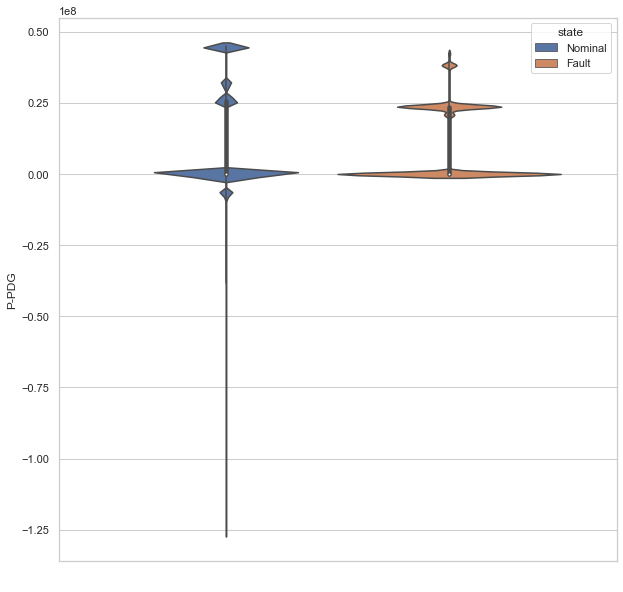

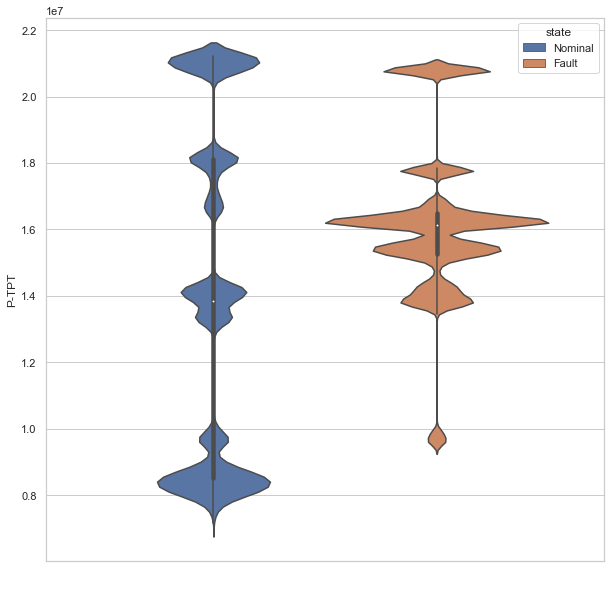

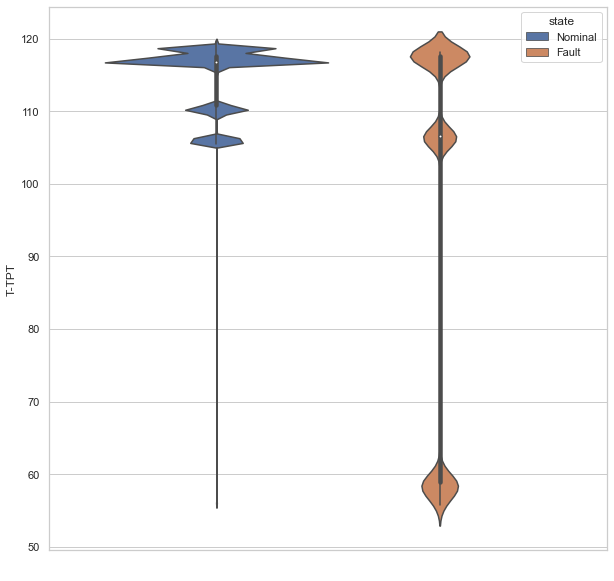

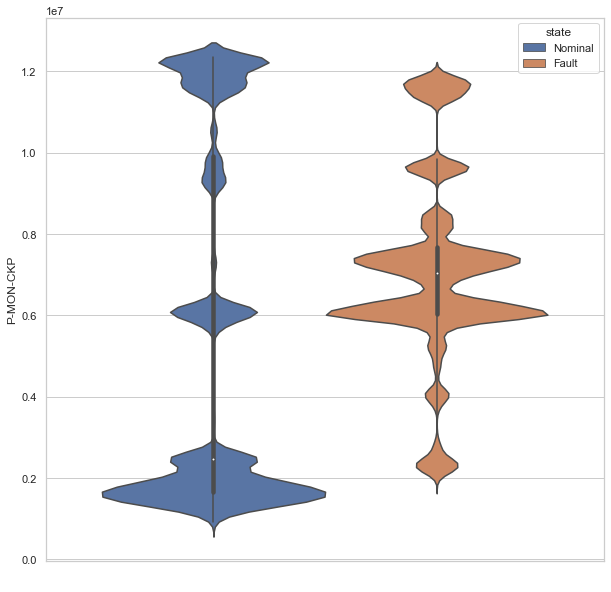

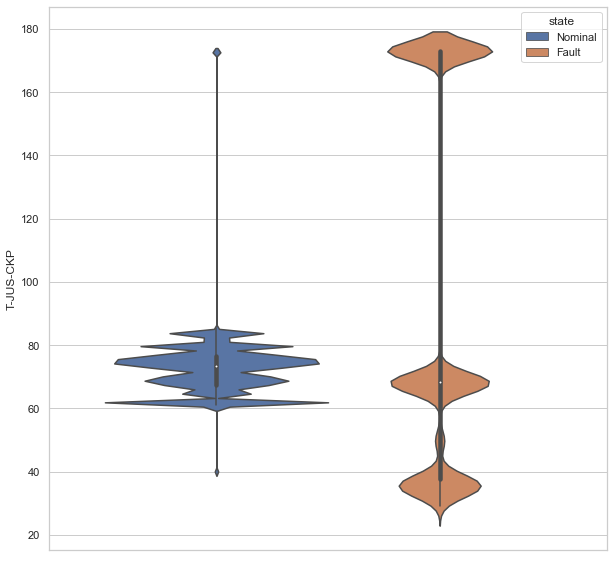

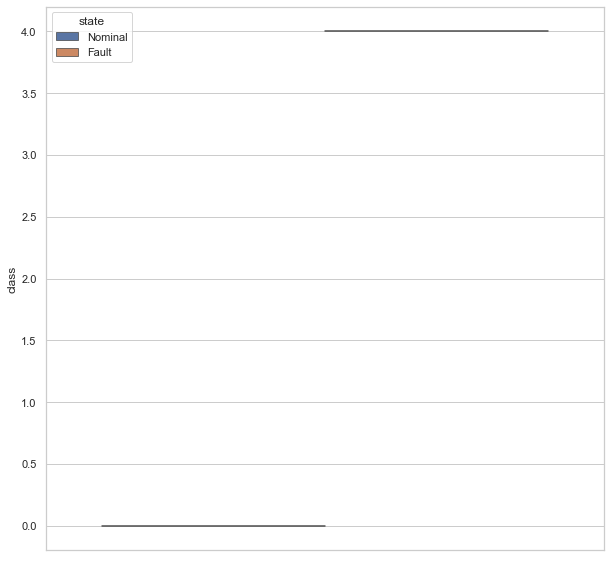

In [138]:
import seaborn as sns
sns.set_theme(style="whitegrid")

for i in range(0,len(frame_total.drop(columns=[' ','state','class']).columns)):
     plt.figure(figsize=(10, 10))
     ax = sns.violinplot(x=" ",y=frame_total.columns[i], hue="state",\
          data=frame_total)
     plt.show()

## Leitura das features em arquivos texto

In [2]:
from numpy import loadtxt
featuresTSFRESH_nom = loadtxt("featuresTSFRESH_nom.txt", comments="#", delimiter=" ", unpack=False)
featuresTSFRESH_fault = loadtxt("FeaturesTSFRESH_fault.txt", comments="#", delimiter=" ", unpack=False)

featuresTSFRESH = np.concatenate((featuresTSFRESH_nom,featuresTSFRESH_fault),axis=0)

In [3]:
# Removendo as 7 primeiras colunas (com features = 0)
featuresTSFRESH = np.concatenate((featuresTSFRESH_nom[:,7:-1],featuresTSFRESH_fault[:,7:-1]),axis=0)

In [4]:
shapeFault = np.shape(featuresTSFRESH_fault)
shapeNom = np.shape(featuresTSFRESH_nom)
shapeFinal = featuresTSFRESH.shape

# Adicionando classes de dados ao dataset:
classe_falt = np.ones(shape = (shapeFault[0],1))
classe_nom = np.zeros(shape = (shapeNom[0],1))
y = np.concatenate((classe_nom,classe_falt), axis = 0)

### Visualização dos dados com violin plot

In [12]:
frameFeaturesTSFRESH = pd.DataFrame(featuresTSFRESH, columns = extracted_features.columns[7:-1])

In [13]:
# colunas auxiliares para a figura
frameFeaturesTSFRESH["state"] = "Fault"
frameFeaturesTSFRESH.iloc[:shapeNom[0],-1] = "Nominal"
frameFeaturesTSFRESH[" "] = ""

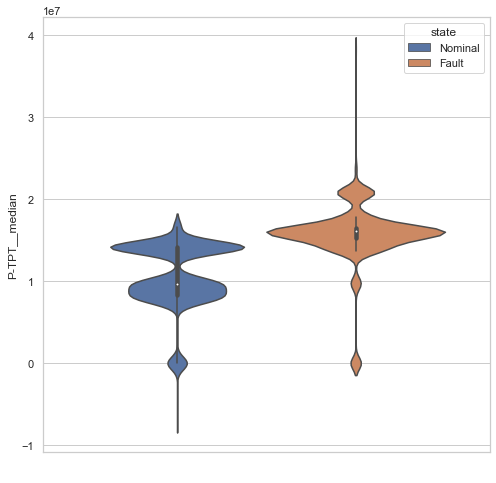

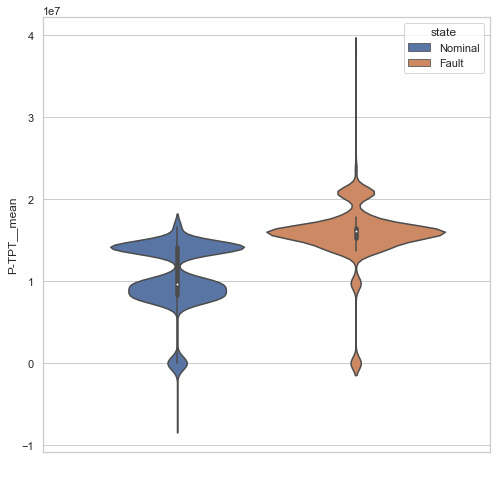

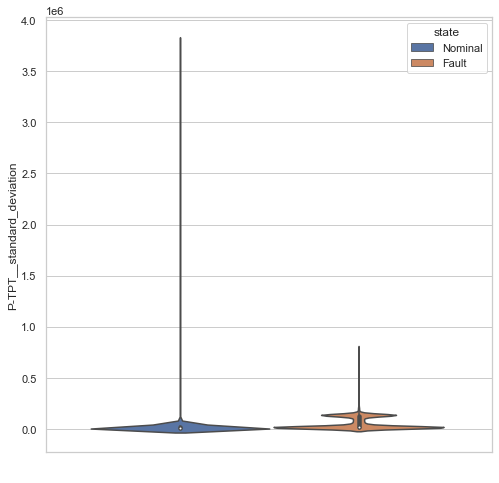

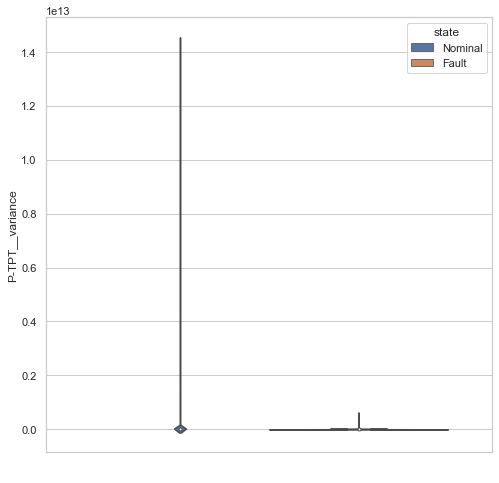

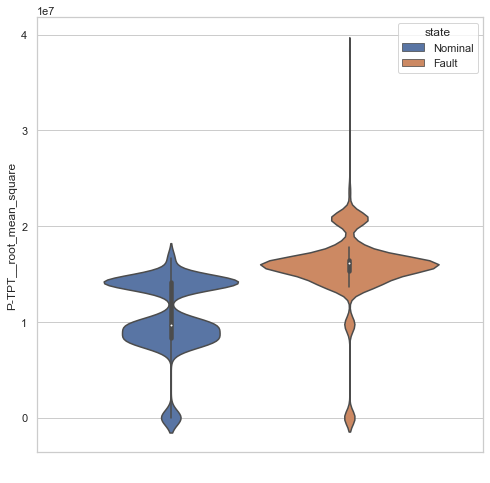

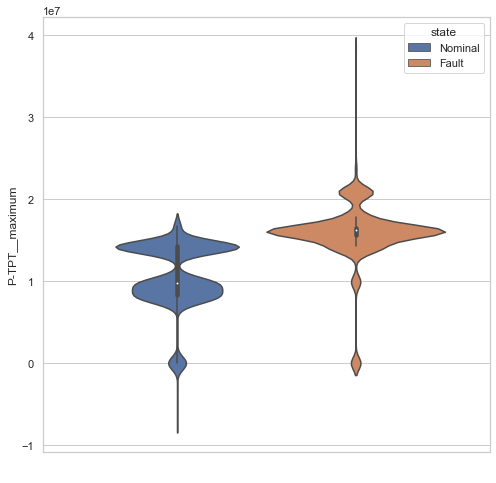

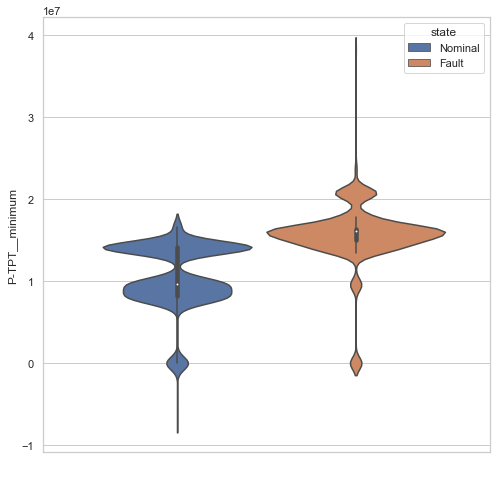

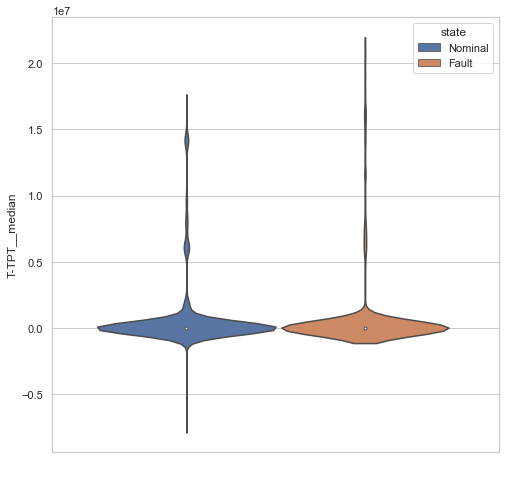

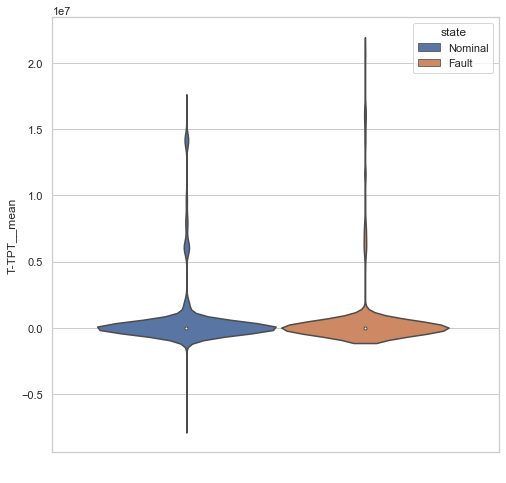

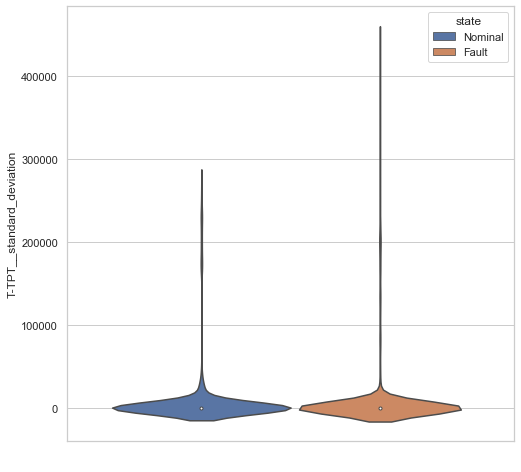

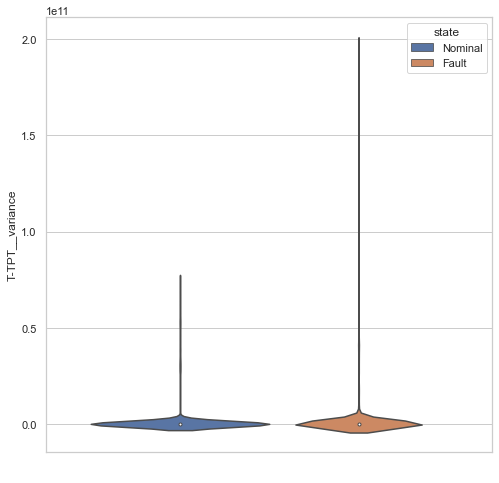

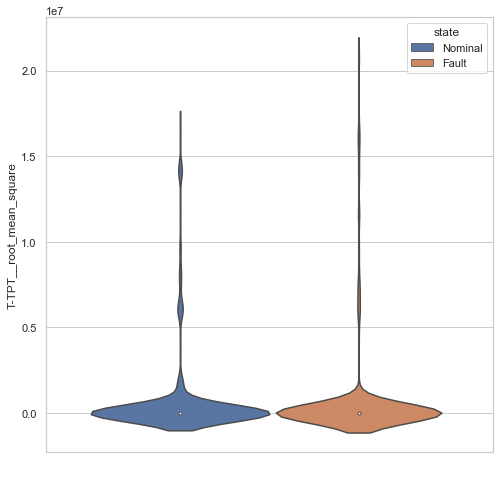

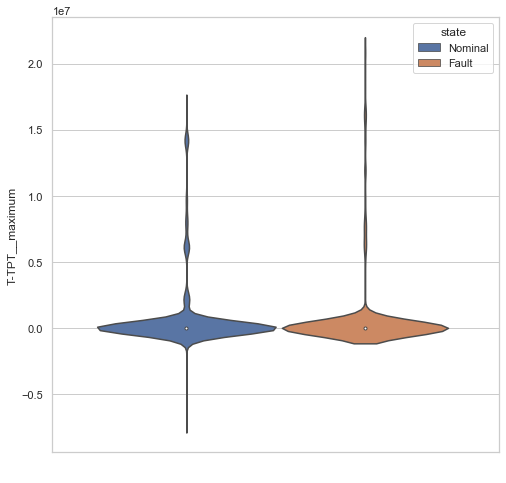

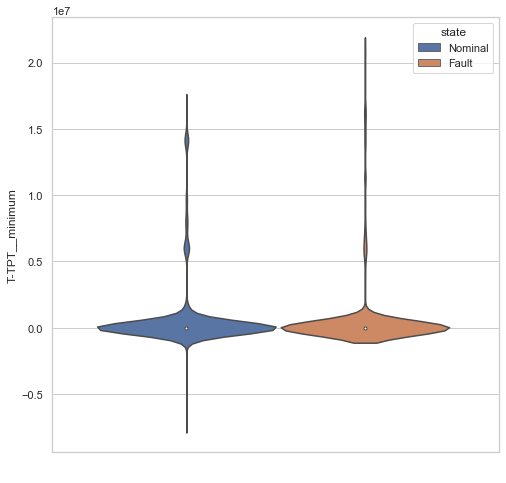

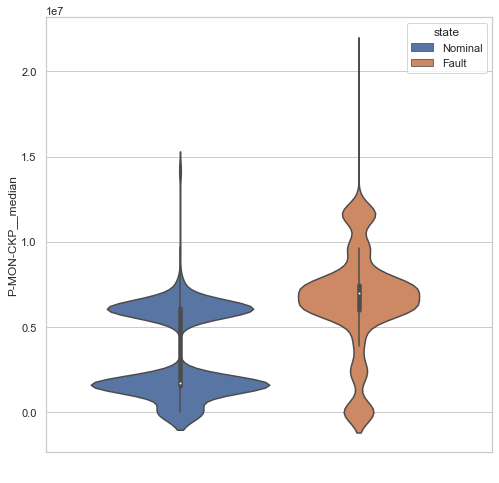

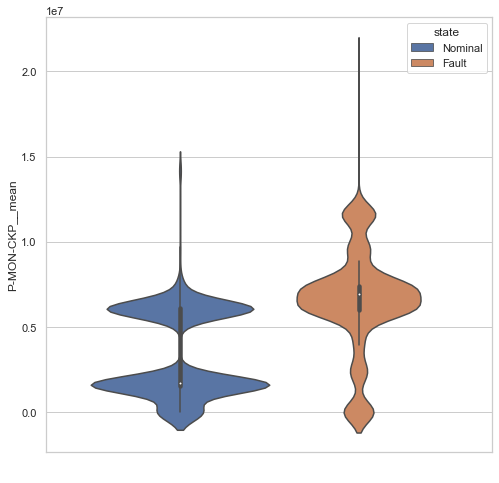

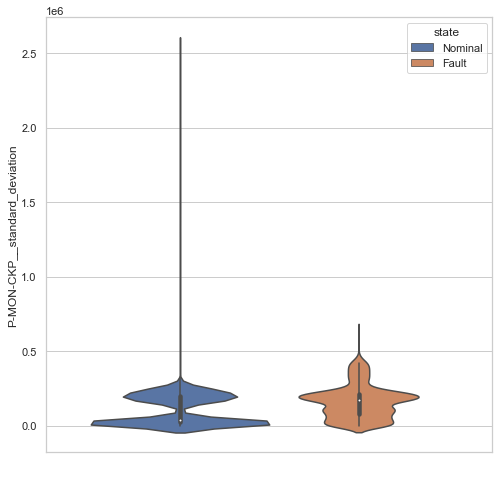

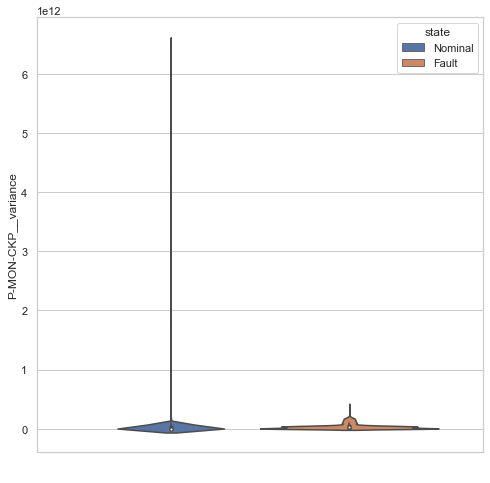

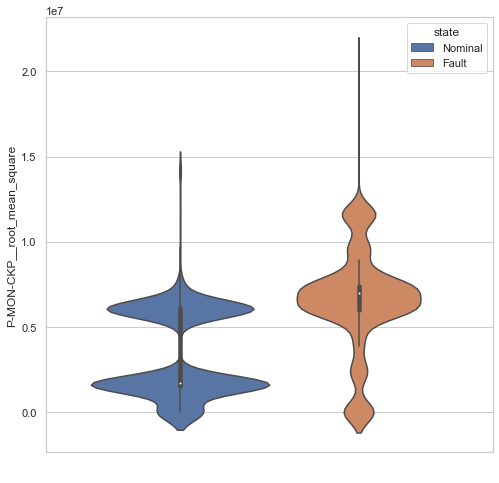

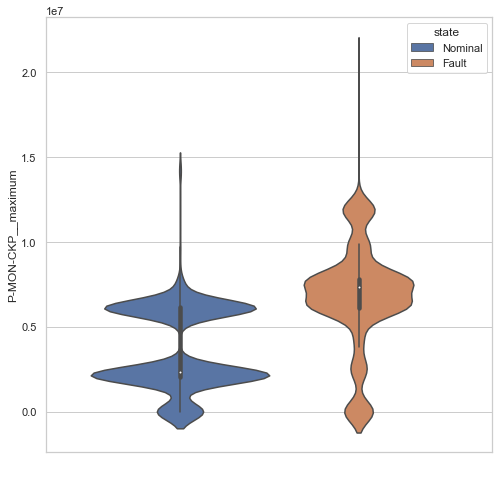

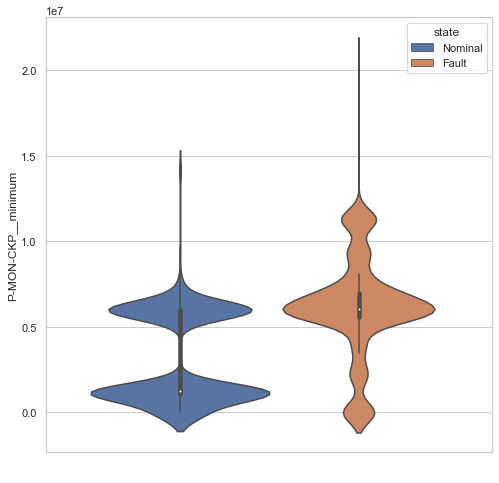

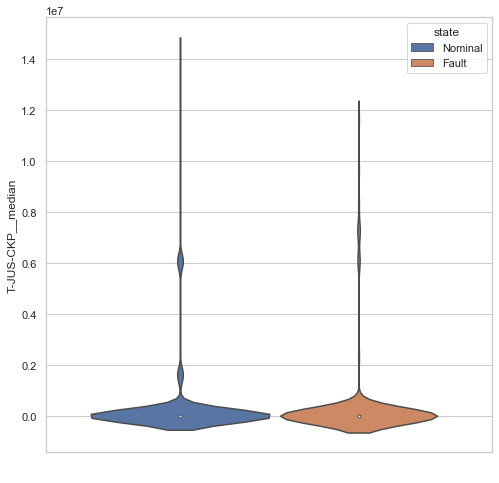

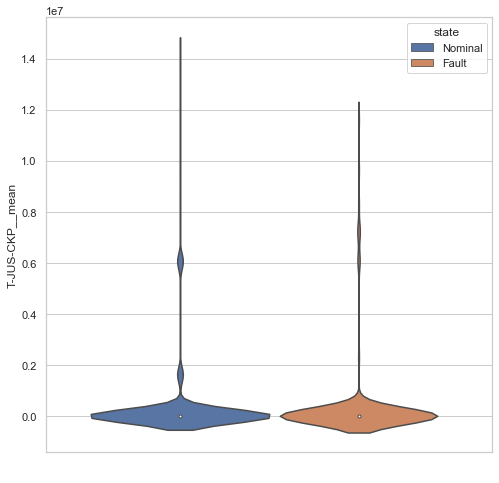

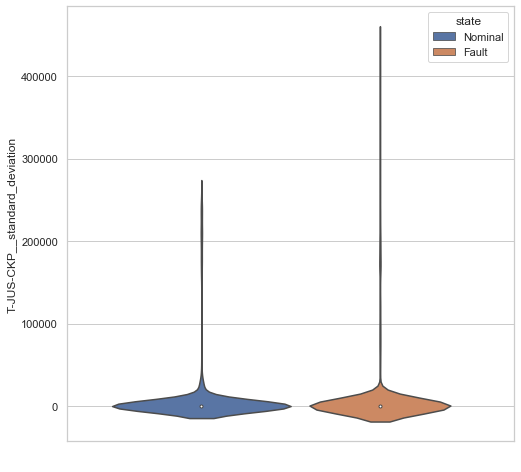

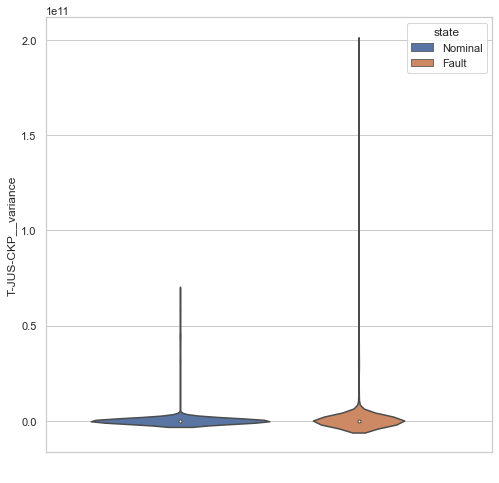

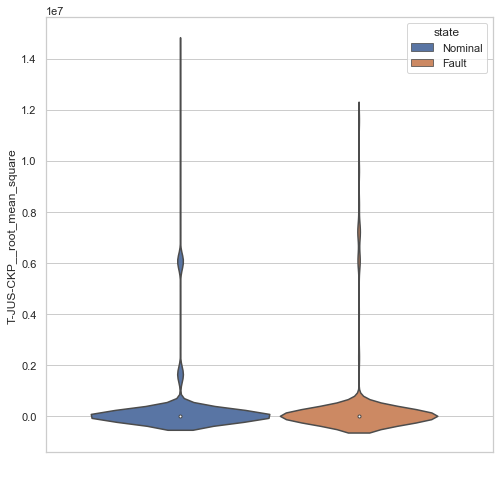

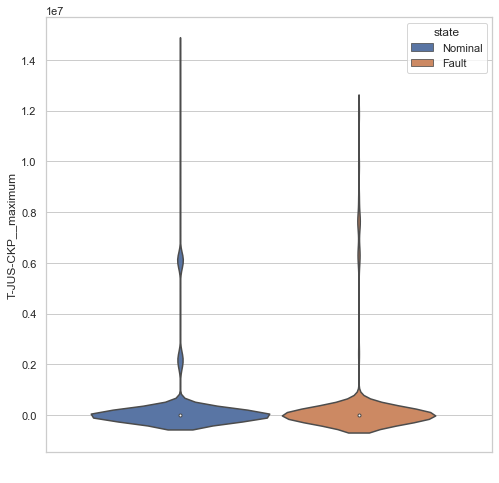

In [14]:
import seaborn as sns
sns.set_theme(style="whitegrid")

for i in range(0,len(frameFeaturesTSFRESH.drop(columns=[' ','state']).columns)):
     plt.figure(figsize=(8, 8))
     ax = sns.violinplot(x=" ",y=frameFeaturesTSFRESH.columns[i], hue="state",\
          data=frameFeaturesTSFRESH)
     plt.show()

## 3. Modelo de aprendizado de máquina:

In [5]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [6]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [7]:
target_names = ['class - Nom', 'class - Fault']

In [8]:
from sklearn.metrics import classification_report
standard_scaler = preprocessing.StandardScaler()
Feat_scaler = standard_scaler.fit_transform(featuresTSFRESH)
Y = y

x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, Y, test_size = 0.2, random_state = 0 )

### Linear Regression

c:\Users\rodri\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


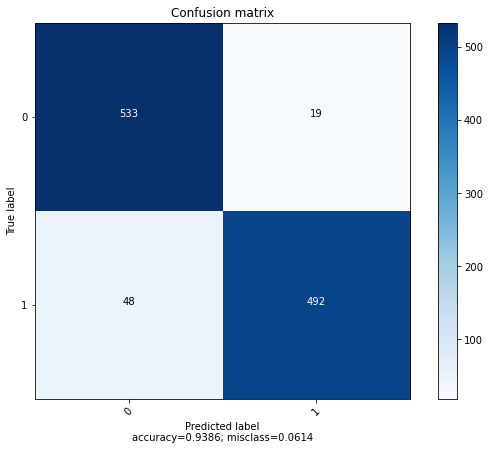

               precision    recall  f1-score   support

  class - Nom     0.9174    0.9656    0.9409       552
class - Fault     0.9628    0.9111    0.9363       540

     accuracy                         0.9386      1092
    macro avg     0.9401    0.9383    0.9386      1092
 weighted avg     0.9399    0.9386    0.9386      1092



In [9]:
from sklearn.linear_model import LogisticRegression

ml = LogisticRegression(random_state=42)
ml.fit(x_train, y_train)

y_pred = ml.predict(x_test)
plot_confusion_matrix(confusion_matrix(y_test,y_pred), target_names= range(0,2))
print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

### a) SVM

c:\Users\rodri\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\rodri\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


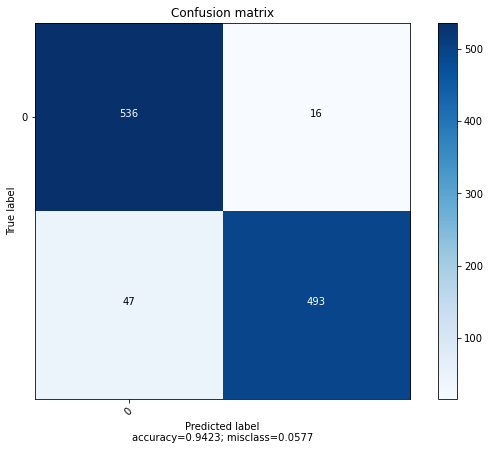

               precision    recall  f1-score   support

  class - Nom     0.9194    0.9710    0.9445       552
class - Fault     0.9686    0.9130    0.9399       540

     accuracy                         0.9423      1092
    macro avg     0.9440    0.9420    0.9422      1092
 weighted avg     0.9437    0.9423    0.9422      1092



In [10]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
standard_scaler = preprocessing.StandardScaler()
Feat_scaler = standard_scaler.fit_transform(featuresTSFRESH)
Y = y

x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, Y, test_size = 0.2, random_state = 0 )
modelo_svc = LinearSVC(C = 1, loss = 'hinge', random_state = 42)
modelo_svc.fit(x_train, y_train)

y_pred = modelo_svc.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(0,1))

print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

In [92]:
np.shape(y_pred)

(1092,)

In [11]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.model_selection import RepeatedKFold

c:\Users\rodri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan -0.06643485 -0.06457947         nan -0.06722696 -0.06599943
 -0.06776767 -0.06538071 -0.06497334         nan -0.06818856         nan
         nan -0.06534903         nan         nan -0.06607722         nan
         nan         nan         nan         nan -0.06589379         nan
         nan -0.06511577         nan         nan         nan         nan
         nan -0.06588916         nan -0.06572003 -0.06585253         nan
 -0.06637036         nan         nan -0.06718087         nan         nan
 -0.06588944 -0.06589421 -0.06646245 -0.06817966 -0.06647562         nan
 -0.06451535         nan         nan -0.06548606         nan         nan
         nan         nan -0.06619169         nan         nan -0.0666134
         nan -0.06738261 -0.06536689         nan         nan -0.06865103
         nan -0.06660893         nan -0.06560523       

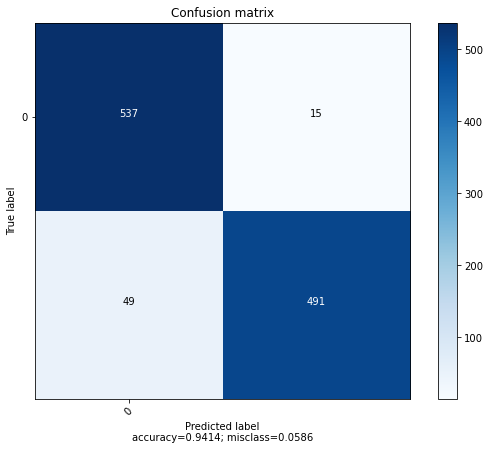

               precision    recall  f1-score   support

  class - Nom     0.9164    0.9728    0.9438       552
class - Fault     0.9704    0.9093    0.9388       540

     accuracy                         0.9414      1092
    macro avg     0.9434    0.9410    0.9413      1092
 weighted avg     0.9431    0.9414    0.9413      1092



In [12]:
rkf = RepeatedKFold(n_splits = 5, n_repeats = 50, random_state = 42)
rkf.split(x_train, y_train)

# Randomized Search
rand_parameters = [{'C':range(1,100), 'loss':['hinge', 'square_hinge']}]
modelo_svc = LinearSVC() 
random_search_svm = RandomizedSearchCV(modelo_svc, rand_parameters, verbose = 0, n_iter = 100,
                                       n_jobs = -1, cv = rkf, scoring = 'neg_mean_squared_error', random_state=42)
random_search_svm.fit(x_train, y_train)
BPSVC = random_search_svm.best_params_

yh = random_search_svm.predict(x_test)

cm = confusion_matrix(y_test, yh)

plot_confusion_matrix(cm, target_names = range(0,1))

print(classification_report(y_test, yh, target_names=target_names,digits=4))

c:\Users\rodri\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\rodri\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


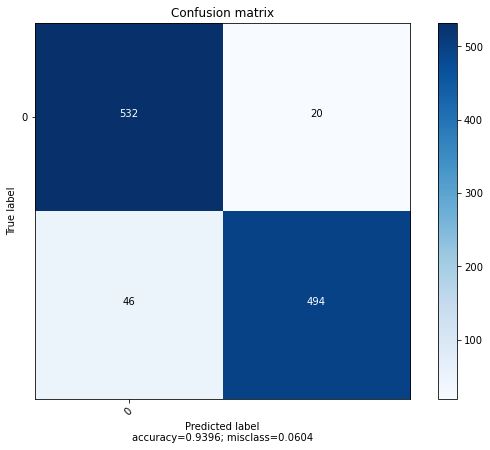

               precision    recall  f1-score   support

  class - Nom     0.9204    0.9638    0.9416       552
class - Fault     0.9611    0.9148    0.9374       540

     accuracy                         0.9396      1092
    macro avg     0.9408    0.9393    0.9395      1092
 weighted avg     0.9405    0.9396    0.9395      1092



In [13]:
x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, Y, test_size = 0.2, random_state = 0 )
modelo_svc = LinearSVC(C = 67, loss = 'hinge', random_state = 42)
modelo_svc.fit(x_train, y_train)

y_pred = modelo_svc.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(0,1))

print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

#### Truque do Kernel

##### a. Kernel polinomial:

c:\Users\rodri\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


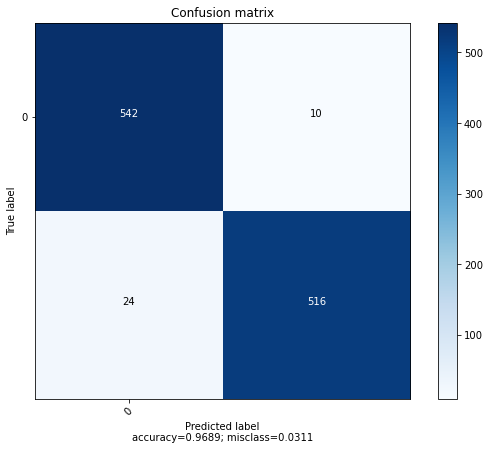

               precision    recall  f1-score   support

  class - Nom     0.9576    0.9819    0.9696       552
class - Fault     0.9810    0.9556    0.9681       540

     accuracy                         0.9689      1092
    macro avg     0.9693    0.9687    0.9688      1092
 weighted avg     0.9692    0.9689    0.9689      1092



In [14]:
modelo_svc = SVC(C = 63, kernel = 'poly', degree = 2, random_state = 42)
modelo_svc.fit(x_train, y_train)

y_pred = modelo_svc.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(0,1))

print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

##### a. Kernel Gaussiano:

c:\Users\rodri\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


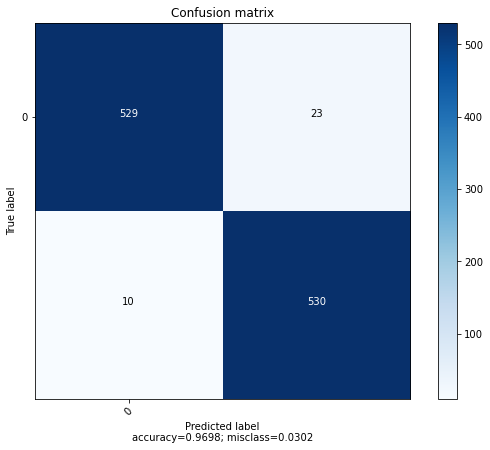

               precision    recall  f1-score   support

  class - Nom     0.9814    0.9583    0.9698       552
class - Fault     0.9584    0.9815    0.9698       540

     accuracy                         0.9698      1092
    macro avg     0.9699    0.9699    0.9698      1092
 weighted avg     0.9701    0.9698    0.9698      1092



In [15]:
modelo_svc = SVC(C = 63, kernel = 'rbf', gamma = 5, random_state = 42)
modelo_svc.fit(x_train, y_train)

y_pred = modelo_svc.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(0,1))

print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

### b) Random Forest

C:\Users\rodri\AppData\Local\Temp/ipykernel_22532/933699177.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train, y_train)


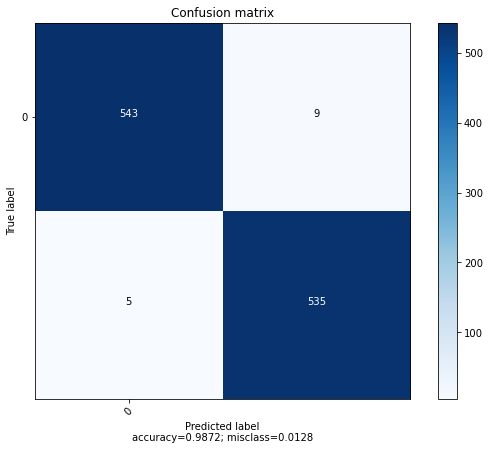

               precision    recall  f1-score   support

  class - Nom     0.9909    0.9837    0.9873       552
class - Fault     0.9835    0.9907    0.9871       540

     accuracy                         0.9872      1092
    macro avg     0.9872    0.9872    0.9872      1092
 weighted avg     0.9872    0.9872    0.9872      1092



In [17]:
from scipy.stats import randint,uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 500, n_jobs= -1)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

plot_confusion_matrix(confusion_matrix(y_test,y_pred), target_names= range(0,1))

print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

In [18]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
            }


# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\rodri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [156]:
from sklearn.model_selection import cross_val_score 


acc = cross_val_score(estimator=rf_random,X=x_train,y=y_train,cv=3)



Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
acc

In [19]:
rf_random.best_params_

{'n_estimators': 900,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 70}

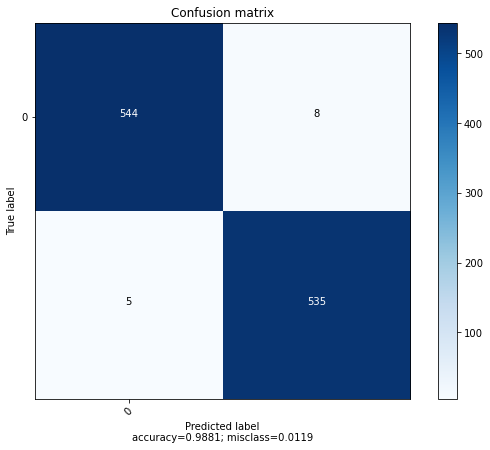

               precision    recall  f1-score   support

  class - Nom     0.9909    0.9855    0.9882       552
class - Fault     0.9853    0.9907    0.9880       540

     accuracy                         0.9881      1092
    macro avg     0.9881    0.9881    0.9881      1092
 weighted avg     0.9881    0.9881    0.9881      1092



In [20]:
y_pred = rf_random.predict(x_test)

plot_confusion_matrix(confusion_matrix(y_test,y_pred), target_names= range(0,1))

print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

## 4. MONTE CARLO

### Monte Carlo

In [99]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split

In [100]:
def monte_carlo_sampler(dataset, n_samples, sample_size=10, 
                        lower_bound=0, upper_bound=100):
    """Gerador de amostras (indices) a serem retirados do 
    dataset total.

    Args:
        dataset (array): Matriz de dados inicial.
        n_samples (int): Número de amostras.
        sample_size (int, optional): Tamanho de cada amostra. Defaults to 10.
        lower_bound (int, optional): limite inferior da amostra. Defaults to 0.
        upper_bound (int, optional): limite superior da amostra. Defaults to 100.

    Returns:
        array: matriz de inputs atualizada 
    """
    
    sample = []
    for i in range(0, n_samples):
        smp = np.random.randint(lower_bound,upper_bound,
                                    size=(1,sample_size))
        sample.append(list(smp[0]))
        
    ds_new = np.zeros(shape=(n_samples*sample_size,dataset.shape[1]))
    c = 0 
    for i in range(0,n_samples):
        for j in sample[i]:
            ds_new[c,:] = dataset[j,:]
            c += 1 
    
    return ds_new

In [114]:
from numpy import loadtxt
featuresTSFRESH_nom = loadtxt("featuresTSFRESH_nom.txt", comments="#", delimiter=" ", unpack=False)
featuresTSFRESH_fault = loadtxt("FeaturesTSFRESH_fault.txt", comments="#", delimiter=" ", unpack=False)
featuresTSFRESH = np.concatenate((featuresTSFRESH_nom[:,7:-1],featuresTSFRESH_fault[:,7:-1]),axis=0)
shapeFault = np.shape(featuresTSFRESH_fault)
shapeNom = np.shape(featuresTSFRESH_nom)
shapeTot = np.shape(featuresTSFRESH)

# Adicionando classes de dados ao dataset:
classe_falt = np.ones(shape = (shapeFault[0],1))
classe_nom = np.zeros(shape = (shapeNom[0],1))
y = np.concatenate((classe_nom, classe_falt), axis = 0)

In [115]:
np.shape(featuresTSFRESH_nom)

(2736, 35)

In [116]:
dataset_test = np.concatenate((featuresTSFRESH, y), axis=1)

#Monte Carlo samples:
n_samples=500
sample_size=500
samples = monte_carlo_sampler(dataset = dataset_test,n_samples=n_samples, 
                              sample_size=sample_size, lower_bound=0, 
                              upper_bound=shapeTot[0])
# samples.shape = (20,28) 
# -> 20 dados (2 amostras c/ 10 valores cada)
# -> 28 dados (27 atributos estátisticos + 1 target)

In [117]:
samples.shape

(250000, 28)

Text(0.5, 1.0, 'Average Score')

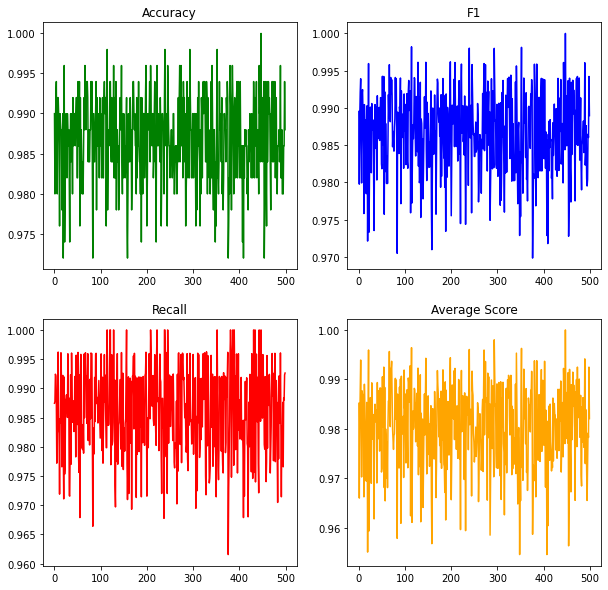

In [118]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, average_precision_score
from sklearn.preprocessing import StandardScaler
#Normalization:
standard_scaler = StandardScaler()
samples_norm = standard_scaler.fit_transform(samples[:,:-1])
Y = samples[:,-1]
# Testando modelo para amostras aleatórias:
acc_per_sample = []
f1_per_sample = []
recall_per_sample = []
average_score = []
for i in range(1,n_samples+1):
        amt_end = i*sample_size - 1
        amt_init = (i-1)*sample_size
        y_pred = modelo_svc.predict(samples_norm[amt_init:amt_end,:])
        y_real = Y[amt_init:amt_end]
        #Métricas do sample:
        acc_per_sample.append(accuracy_score(y_real, y_pred))
        f1_per_sample.append(f1_score(y_real, y_pred))
        recall_per_sample.append(recall_score(y_real, y_pred))
        average_score.append(average_precision_score(y_real, y_pred))

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].plot(acc_per_sample,'g', label = 'accuracy')  
ax[0,0].set_title('Accuracy')  
ax[0,1].plot(f1_per_sample,'b', label = 'f1')  
ax[0,1].set_title('F1')  
ax[1,0].plot(recall_per_sample,'r', label = 'recall')  
ax[1,0].set_title('Recall')  
ax[1,1].plot(average_score,'orange', label = 'Average Score')  
ax[1,1].set_title('Average Score')  

### Monte Carlo TSFRESH Application:

In [119]:
from scipy.stats import randint,uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

#Scaling and normalization:
standard_scaler = preprocessing.StandardScaler()
Feat_scaler = standard_scaler.fit_transform(featuresTSFRESH)
x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, y, test_size = 0.2, random_state = 0 )

#Random Forest:
model_rfc = RandomForestClassifier(n_estimators = 400, n_jobs= -1,random_state = 42)
model_rfc.fit(x_train, y_train)

#SVC Linear
model_svc = LinearSVC(C = 7, loss = 'hinge', random_state = 42)
model_svc.fit(x_train, y_train)

#SVC polinomial
model_svcPoly = SVC(C = 7, kernel = 'poly', degree = 3, random_state = 42)
model_svcPoly.fit(x_train, y_train)

#SVC RBG
modelo_svcRBG = SVC(C = 63, kernel = 'rbf', gamma = 5, random_state = 42)
modelo_svcRBG.fit(x_train, y_train)

#Logistic Regression
model_LogReg = linear_model.LogisticRegression(random_state = 42)
model_LogReg.fit(x_train,y_train)

C:\Users\rodri\AppData\Local\Temp/ipykernel_1112/2466970631.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rfc.fit(x_train, y_train)
c:\Users\rodri\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\rodri\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\Users\rodri\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\rodri

LogisticRegression(random_state=42)

In [120]:
#Normalization:
standard_scaler = StandardScaler()
samples_norm = standard_scaler.fit_transform(samples[:,:-1])
Y = samples[:,-1]
# Testando modelo para amostras aleatórias:
acc, F1, recall, avgScr = {},{},{},{}
models = [model_rfc, model_svc, model_svcPoly, modelo_svcRBG, model_LogReg]
for MODEL in models:
        acc_per_sample = []
        f1_per_sample = []
        recall_per_sample = []
        average_score = []
        for i in range(1,n_samples+1):
                amt_end = i*sample_size - 1
                amt_init = (i-1)*sample_size
                y_pred = MODEL.predict(samples_norm[amt_init:amt_end,:])
                y_real = Y[amt_init:amt_end]
                #Métricas do sample:
                acc_per_sample.append(accuracy_score(y_real, y_pred))
                f1_per_sample.append(f1_score(y_real, y_pred))
                recall_per_sample.append(recall_score(y_real, y_pred))
                average_score.append(average_precision_score(y_real, y_pred))   
        #Save metrics:
        acc[MODEL] = acc_per_sample
        F1[MODEL]  = f1_per_sample
        recall[MODEL] = recall_per_sample
        avgScr[MODEL] = average_score

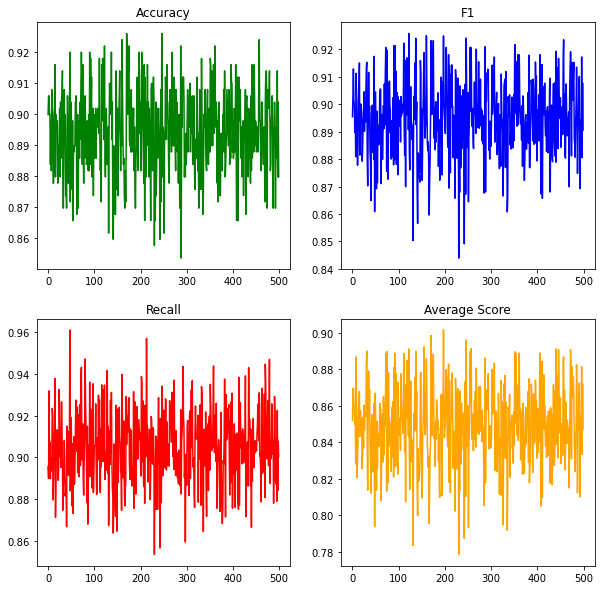

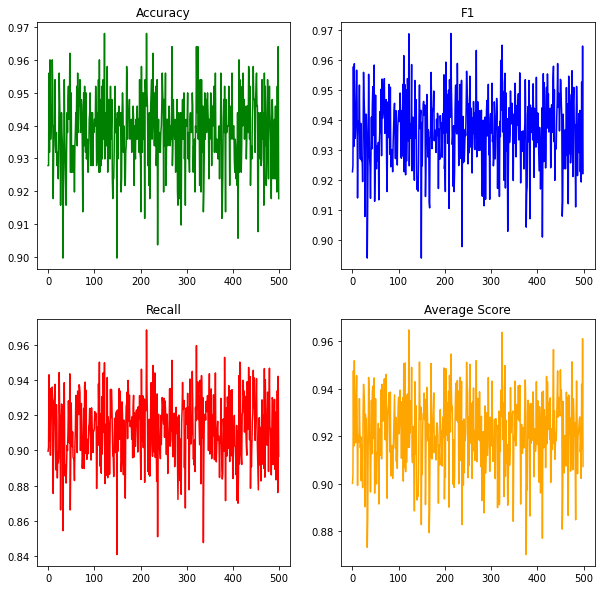

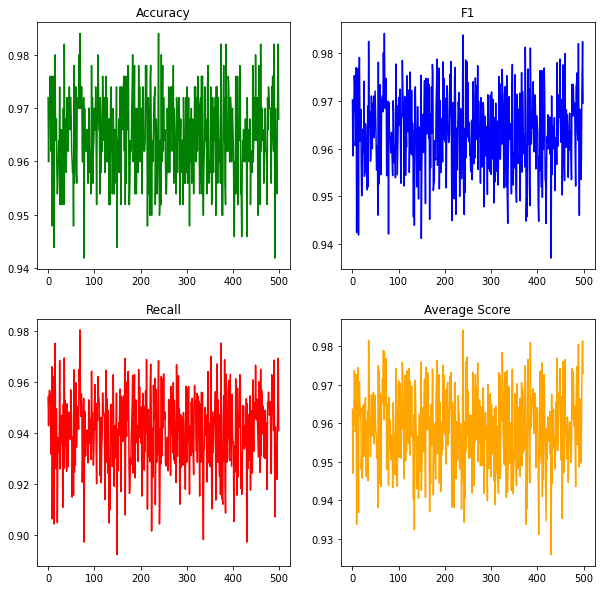

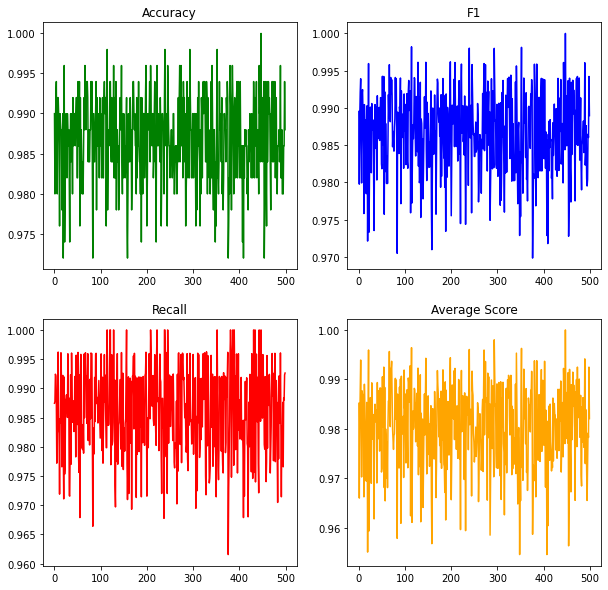

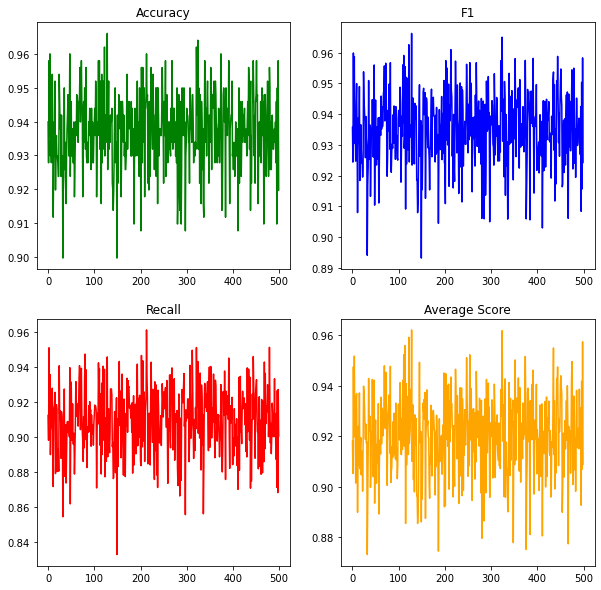

In [121]:
for i in models:
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    ax[0,0].plot(acc[i],'g', label = 'accuracy')  
    ax[0,0].set_title('Accuracy')  
    ax[0,1].plot(F1[i],'b', label = 'f1')  
    ax[0,1].set_title('F1')  
    ax[1,0].plot(recall[i],'r', label = 'recall')  
    ax[1,0].set_title('Recall')  
    ax[1,1].plot(avgScr[i],'orange', label = 'Average Score')  
    ax[1,1].set_title('Average Score') 
    name = i
    fig.savefig(str(name) + '.png')

In [122]:
atb = ['Acurácia', 'F1', 'Recall','AvgScr']
m = ['LG', 'SVM','SVM-POLY','SVM-RGB','RF']

# Acurácia
df_acc_1 = pd.DataFrame(acc[models[0]], columns=[m[0]+'-'+atb[0]])      
df_acc_2 = pd.DataFrame(acc[models[1]], columns=[m[1]+'-'+atb[0]])      
df_acc_3 = pd.DataFrame(acc[models[2]], columns=[m[2]+'-'+atb[0]])      
df_acc_4 = pd.DataFrame(acc[models[3]], columns=[m[3]+'-'+atb[0]])      
df_acc_5 = pd.DataFrame(acc[models[4]], columns=[m[4]+'-'+atb[0]])      
df_ACC = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

# F1
df_acc_1 = pd.DataFrame(F1[models[0]], columns=[m[0]+'-'+atb[1]])      
df_acc_2 = pd.DataFrame(F1[models[1]], columns=[m[1]+'-'+atb[1]])      
df_acc_3 = pd.DataFrame(F1[models[2]], columns=[m[2]+'-'+atb[1]])      
df_acc_4 = pd.DataFrame(F1[models[3]], columns=[m[3]+'-'+atb[1]])      
df_acc_5 = pd.DataFrame(F1[models[4]], columns=[m[4]+'-'+atb[1]])      
df_F1 = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

# RECALL
df_acc_1 = pd.DataFrame(recall[models[0]], columns=[m[0]+'-'+atb[2]])      
df_acc_2 = pd.DataFrame(recall[models[1]], columns=[m[1]+'-'+atb[2]])      
df_acc_3 = pd.DataFrame(recall[models[2]], columns=[m[2]+'-'+atb[2]])      
df_acc_4 = pd.DataFrame(recall[models[3]], columns=[m[3]+'-'+atb[2]])      
df_acc_5 = pd.DataFrame(recall[models[4]], columns=[m[4]+'-'+atb[2]])      
df_REC = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

# AVGSCR
df_acc_1 = pd.DataFrame(avgScr[models[0]], columns=[m[0]+'-'+atb[3]])      
df_acc_2 = pd.DataFrame(avgScr[models[1]], columns=[m[1]+'-'+atb[3]])      
df_acc_3 = pd.DataFrame(avgScr[models[2]], columns=[m[2]+'-'+atb[3]])      
df_acc_4 = pd.DataFrame(avgScr[models[3]], columns=[m[3]+'-'+atb[3]])      
df_acc_5 = pd.DataFrame(avgScr[models[4]], columns=[m[4]+'-'+atb[3]])      
df_AVG = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

dados_gerais = pd.concat([df_ACC,df_F1,df_REC,df_AVG], axis = 1)

# dados_gerais.to_csv('dados_montecarlo.csv')

In [123]:
df = dados_gerais.describe()
df.to_csv('dados_montecarlo_describe.csv')

### Monte Carlo to PCA:

In [155]:
path = r'3W\4' # use your path 3W\4
all_files = glob.glob(path + "/*.csv")
li = {}
c = 0
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header = 0)
    df = df.drop(columns = ['timestamp','QGL','T-JUS-CKGL','P-JUS-CKGL'])
    li[c] = df
    c += 1
    
frame = pd.concat(li, axis=0, ignore_index=True)

dados = li # dicionário 
Feat = []
lags = 30
for i in range(0, 149):
# for i in range(0, 2):
    ch = dados[i]
    chss = []
    ch1 = AutoReg(ch[ch.columns[0]].values,lags = lags).fit()
    ch2 = AutoReg(ch[ch.columns[1]].values,lags = lags).fit()
    ch3 = AutoReg(ch[ch.columns[2]].values,lags = lags).fit()
    ch4 = AutoReg(ch[ch.columns[3]].values,lags = lags).fit()
    ch5 = AutoReg(ch[ch.columns[4]].values,lags = lags).fit()
    # ch6 = AutoReg(ch[ch.columns[5]].values,lags = lags).fit()        
    ar_models = np.concatenate([ch1.params, ch2.params, ch3.params,
                                ch4.params, ch5.params]) #], ch6.params])
    Feat.append(ar_models)
    
# Só foi até o 149 -> apareceu nan's!!! 
# Talvez fazer um modelo de para completar dados faltantes!!!

In [156]:
path = r'3W\0' # use your path 3W\4
all_files = glob.glob(path + "/*.csv")
li = {}
c = 0
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header = 0)
    df = df.drop(columns = ['timestamp','QGL','T-JUS-CKGL'])
    li[c] = df
    c += 1

frame = pd.concat(li, axis=0, ignore_index=True)
dados = li # dicionário 
lags = 30
for i in range(0, 150):
# for i in range(0, 2):
    ch = dados[i]
    chss = []
    ch1 = AutoReg(ch[ch.columns[0]].values,lags = lags).fit()
    ch2 = AutoReg(ch[ch.columns[1]].values,lags = lags).fit()
    ch3 = AutoReg(ch[ch.columns[2]].values,lags = lags).fit()
    ch4 = AutoReg(ch[ch.columns[3]].values,lags = lags).fit()
    ch5 = AutoReg(ch[ch.columns[4]].values,lags = lags).fit()
    # ch6 = AutoReg(ch[ch.columns[5]].values,lags = lags).fit()        
    ar_models = np.concatenate([ch1.params, ch2.params, ch3.params,
                                ch4.params, ch5.params])# ch6.params])
    Feat.append(ar_models)

In [161]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)
Feat_reduced_nom = pca.fit_transform(Feat)
Feat_reduced_nom.shape

# # Adicionando classes de dados ao dataset:
classe_falt = np.ones(shape = (149,1))
classe_nom = np.zeros(shape = (150,1))
Dados_2CP = np.concatenate((Feat_reduced, classes), axis = 1)

pca = PCA(n_components = 3)
Feat_reduced = pca.fit_transform(Feat)
Dados_3CP = np.concatenate((Feat_reduced, classes), axis = 1)

In [166]:
dataset_test_2CP = Dados_2CP
dataset_test_3CP = Dados_3CP

#Monte Carlo samples:
n_samples=250
sample_size=100
samples_2cp = monte_carlo_sampler(dataset = dataset_test_2CP,n_samples=n_samples, 
                              sample_size=sample_size, lower_bound=0, 
                              upper_bound=dataset_test_2CP.shape[0])

samples_3cp = monte_carlo_sampler(dataset = dataset_test_3CP,n_samples=n_samples, 
                              sample_size=sample_size, lower_bound=0, 
                              upper_bound=dataset_test_3CP.shape[0])
# samples.shape = (20,28) 
# -> 20 dados (2 amostras c/ 10 valores cada)
# -> 28 dados (27 atributos estátisticos + 1 target)

#### PCA_2CP

In [169]:
from scipy.stats import randint,uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

#Scaling and normalization:
standard_scaler = preprocessing.StandardScaler()
Feat_scaler = standard_scaler.fit_transform(dataset_test_2CP[:,:-1])
y = dataset_test_2CP[:,-1]
x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, y, test_size = 0.2, random_state = 0 )

#Random Forest:
model_rfc = RandomForestClassifier(n_estimators = 400, n_jobs= -1,random_state = 42)
model_rfc.fit(x_train, y_train)

#SVC Linear
model_svc = LinearSVC(C = 79, loss = 'hinge', random_state = 42)
model_svc.fit(x_train, y_train)

#SVC polinomial
model_svcPoly = SVC(C = 79, kernel = 'poly', degree = 3, random_state = 42)
model_svcPoly.fit(x_train, y_train)

#SVC RBG
modelo_svcRBG = SVC(C = 63, kernel = 'rbf', gamma = 5, random_state = 42)
modelo_svcRBG.fit(x_train, y_train)

#Logistic Regression
model_LogReg = linear_model.LogisticRegression(random_state = 42)
model_LogReg.fit(x_train,y_train)

c:\Users\luissantos\Documents\HIML\HIML_E3\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(random_state=42)

In [170]:
#Normalization:
standard_scaler = StandardScaler()
samples_norm = standard_scaler.fit_transform(samples_2cp[:,:-1])
Y = samples_2cp[:,-1]
# Testando modelo para amostras aleatórias:
acc, F1, recall, avgScr = {},{},{},{}
models = [model_rfc, model_svc, model_svcPoly, modelo_svcRBG, model_LogReg]
for MODEL in models:
        acc_per_sample = []
        f1_per_sample = []
        recall_per_sample = []
        average_score = []
        for i in range(1,n_samples+1):
                amt_end = i*sample_size - 1
                amt_init = (i-1)*sample_size
                y_pred = MODEL.predict(samples_norm[amt_init:amt_end,:])
                y_real = Y[amt_init:amt_end]
                #Métricas do sample:
                acc_per_sample.append(accuracy_score(y_real, y_pred))
                f1_per_sample.append(f1_score(y_real, y_pred))
                recall_per_sample.append(recall_score(y_real, y_pred))
                average_score.append(average_precision_score(y_real, y_pred))   
        #Save metrics:
        acc[MODEL] = acc_per_sample
        F1[MODEL]  = f1_per_sample
        recall[MODEL] = recall_per_sample
        avgScr[MODEL] = average_score

In [171]:
atb = ['Acurácia', 'F1', 'Recall','AvgScr']
m = ['LG', 'SVM','SVM-POLY','SVM-RGB','RF']

# Acurácia
df_acc_1 = pd.DataFrame(acc[models[0]], columns=[m[0]+'-'+atb[0]])      
df_acc_2 = pd.DataFrame(acc[models[1]], columns=[m[1]+'-'+atb[0]])      
df_acc_3 = pd.DataFrame(acc[models[2]], columns=[m[2]+'-'+atb[0]])      
df_acc_4 = pd.DataFrame(acc[models[3]], columns=[m[3]+'-'+atb[0]])      
df_acc_5 = pd.DataFrame(acc[models[4]], columns=[m[4]+'-'+atb[0]])      
df_ACC = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

# F1
df_acc_1 = pd.DataFrame(F1[models[0]], columns=[m[0]+'-'+atb[1]])      
df_acc_2 = pd.DataFrame(F1[models[1]], columns=[m[1]+'-'+atb[1]])      
df_acc_3 = pd.DataFrame(F1[models[2]], columns=[m[2]+'-'+atb[1]])      
df_acc_4 = pd.DataFrame(F1[models[3]], columns=[m[3]+'-'+atb[1]])      
df_acc_5 = pd.DataFrame(F1[models[4]], columns=[m[4]+'-'+atb[1]])      
df_F1 = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

# RECALL
df_acc_1 = pd.DataFrame(recall[models[0]], columns=[m[0]+'-'+atb[2]])      
df_acc_2 = pd.DataFrame(recall[models[1]], columns=[m[1]+'-'+atb[2]])      
df_acc_3 = pd.DataFrame(recall[models[2]], columns=[m[2]+'-'+atb[2]])      
df_acc_4 = pd.DataFrame(recall[models[3]], columns=[m[3]+'-'+atb[2]])      
df_acc_5 = pd.DataFrame(recall[models[4]], columns=[m[4]+'-'+atb[2]])      
df_REC = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

# AVGSCR
df_acc_1 = pd.DataFrame(avgScr[models[0]], columns=[m[0]+'-'+atb[3]])      
df_acc_2 = pd.DataFrame(avgScr[models[1]], columns=[m[1]+'-'+atb[3]])      
df_acc_3 = pd.DataFrame(avgScr[models[2]], columns=[m[2]+'-'+atb[3]])      
df_acc_4 = pd.DataFrame(avgScr[models[3]], columns=[m[3]+'-'+atb[3]])      
df_acc_5 = pd.DataFrame(avgScr[models[4]], columns=[m[4]+'-'+atb[3]])      
df_AVG = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

dados_gerais = pd.concat([df_ACC,df_F1,df_REC,df_AVG], axis = 1)

dados_gerais.to_csv('dados_montecarlo_2cp.csv')
df = dados_gerais.describe()
df.to_csv('dados_montecarlo_describe_2cp.csv')

#### PCA_3CP

In [172]:
#Scaling and normalization:
standard_scaler = preprocessing.StandardScaler()
Feat_scaler = standard_scaler.fit_transform(dataset_test_3CP[:,:-1])
y = dataset_test_3CP[:,-1]
x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, y, test_size = 0.2, random_state = 0 )

#Random Forest:
model_rfc = RandomForestClassifier(n_estimators = 400, n_jobs= -1,random_state = 42)
model_rfc.fit(x_train, y_train)

#SVC Linear
model_svc = LinearSVC(C = 79, loss = 'hinge', random_state = 42)
model_svc.fit(x_train, y_train)

#SVC polinomial
model_svcPoly = SVC(C = 79, kernel = 'poly', degree = 3, random_state = 42)
model_svcPoly.fit(x_train, y_train)

#SVC RBG
modelo_svcRBG = SVC(C = 63, kernel = 'rbf', gamma = 5, random_state = 42)
modelo_svcRBG.fit(x_train, y_train)

#Logistic Regression
model_LogReg = linear_model.LogisticRegression(random_state = 42)
model_LogReg.fit(x_train,y_train)

c:\Users\luissantos\Documents\HIML\HIML_E3\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(random_state=42)

In [173]:
#Normalization:
standard_scaler = StandardScaler()
samples_norm = standard_scaler.fit_transform(samples_3cp[:,:-1])
Y = samples_3cp[:,-1]
# Testando modelo para amostras aleatórias:
acc, F1, recall, avgScr = {},{},{},{}
models = [model_rfc, model_svc, model_svcPoly, modelo_svcRBG, model_LogReg]
for MODEL in models:
        acc_per_sample = []
        f1_per_sample = []
        recall_per_sample = []
        average_score = []
        for i in range(1,n_samples+1):
                amt_end = i*sample_size - 1
                amt_init = (i-1)*sample_size
                y_pred = MODEL.predict(samples_norm[amt_init:amt_end,:])
                y_real = Y[amt_init:amt_end]
                #Métricas do sample:
                acc_per_sample.append(accuracy_score(y_real, y_pred))
                f1_per_sample.append(f1_score(y_real, y_pred))
                recall_per_sample.append(recall_score(y_real, y_pred))
                average_score.append(average_precision_score(y_real, y_pred))   
        #Save metrics:
        acc[MODEL] = acc_per_sample
        F1[MODEL]  = f1_per_sample
        recall[MODEL] = recall_per_sample
        avgScr[MODEL] = average_score

In [174]:
atb = ['Acurácia', 'F1', 'Recall','AvgScr']
m = ['LG', 'SVM','SVM-POLY','SVM-RGB','RF']

# Acurácia
df_acc_1 = pd.DataFrame(acc[models[0]], columns=[m[0]+'-'+atb[0]])      
df_acc_2 = pd.DataFrame(acc[models[1]], columns=[m[1]+'-'+atb[0]])      
df_acc_3 = pd.DataFrame(acc[models[2]], columns=[m[2]+'-'+atb[0]])      
df_acc_4 = pd.DataFrame(acc[models[3]], columns=[m[3]+'-'+atb[0]])      
df_acc_5 = pd.DataFrame(acc[models[4]], columns=[m[4]+'-'+atb[0]])      
df_ACC = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

# F1
df_acc_1 = pd.DataFrame(F1[models[0]], columns=[m[0]+'-'+atb[1]])      
df_acc_2 = pd.DataFrame(F1[models[1]], columns=[m[1]+'-'+atb[1]])      
df_acc_3 = pd.DataFrame(F1[models[2]], columns=[m[2]+'-'+atb[1]])      
df_acc_4 = pd.DataFrame(F1[models[3]], columns=[m[3]+'-'+atb[1]])      
df_acc_5 = pd.DataFrame(F1[models[4]], columns=[m[4]+'-'+atb[1]])      
df_F1 = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

# RECALL
df_acc_1 = pd.DataFrame(recall[models[0]], columns=[m[0]+'-'+atb[2]])      
df_acc_2 = pd.DataFrame(recall[models[1]], columns=[m[1]+'-'+atb[2]])      
df_acc_3 = pd.DataFrame(recall[models[2]], columns=[m[2]+'-'+atb[2]])      
df_acc_4 = pd.DataFrame(recall[models[3]], columns=[m[3]+'-'+atb[2]])      
df_acc_5 = pd.DataFrame(recall[models[4]], columns=[m[4]+'-'+atb[2]])      
df_REC = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

# AVGSCR
df_acc_1 = pd.DataFrame(avgScr[models[0]], columns=[m[0]+'-'+atb[3]])      
df_acc_2 = pd.DataFrame(avgScr[models[1]], columns=[m[1]+'-'+atb[3]])      
df_acc_3 = pd.DataFrame(avgScr[models[2]], columns=[m[2]+'-'+atb[3]])      
df_acc_4 = pd.DataFrame(avgScr[models[3]], columns=[m[3]+'-'+atb[3]])      
df_acc_5 = pd.DataFrame(avgScr[models[4]], columns=[m[4]+'-'+atb[3]])      
df_AVG = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

dados_gerais = pd.concat([df_ACC,df_F1,df_REC,df_AVG], axis = 1)

dados_gerais.to_csv('dados_montecarlo_3cp.csv')
df = dados_gerais.describe()
df.to_csv('dados_montecarlo_describe_3cp.csv')

### Monte Carlo Retreinando cada modelo:

In [29]:
#referente a nova implementação: 
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint,uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
import matplotlib.pyplot as plt
#Normalization:
standard_scaler = StandardScaler()
samples_norm = standard_scaler.fit_transform(samples[:,:-1])
Y = samples[:,-1]
#Modelos:
model_rfc = RandomForestClassifier(n_estimators = 400, n_jobs= -1,random_state = 42)
model_svc = LinearSVC(C = 7, loss = 'hinge', random_state = 42)
model_svcPoly = SVC(C = 7, kernel = 'poly', degree = 3, random_state = 42)
modelo_svcRBG = SVC(C = 63, kernel = 'rbf', gamma = 5, random_state = 42)
model_LogReg = linear_model.LogisticRegression(random_state = 42)
models = [model_LogReg, model_svc, model_svcPoly,
           modelo_svcRBG, model_rfc]
#Treinando e avaliando cada modelo:
acc, F1, recall, avgScr = {},{},{},{}
for MODEL in models:
    acc_per_sample = []
    f1_per_sample = []
    recall_per_sample = []
    average_score = []
    for i in range(1,n_samples+1):
        amt_end = i*sample_size - 1
        amt_init = (i-1)*sample_size
        x_train, x_test, y_train, y_test = train_test_split(samples_norm[amt_init:amt_end,:], 
                                                            Y[amt_init:amt_end], test_size = 0.2, 
                                                            stratify = Y[amt_init:amt_end])
        # Treino
        model = MODEL
        model.fit(x_train, y_train)
        # Previsão 
        y_pred = model.predict(x_test)
        y_real = y_test
        #Métricas do sample:
        acc_per_sample.append(accuracy_score(y_real, y_pred))
        f1_per_sample.append(f1_score(y_real, y_pred))
        recall_per_sample.append(recall_score(y_real, y_pred))
        average_score.append(average_precision_score(y_real, y_pred))
    #Save metrics:
    acc[MODEL] = acc_per_sample
    F1[MODEL]  = f1_per_sample
    recall[MODEL] = recall_per_sample
    avgScr[MODEL] = average_score

c:\Users\luissantos\Documents\HIML\HIML_E3\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\luissantos\Documents\HIML\HIML_E3\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\luissantos\Documents\HIML\HIML_E3\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\luissantos\Documents\HIML\HIML_E3\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\luissantos\Documents\HIML\HIML_E3\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\luissantos\

In [30]:
atb = ['Acurácia', 'F1', 'Recall','AvgScr']
m = ['LG', 'SVM','SVM-POLY','SVM-RGB','RF']

# Acurácia
df_acc_1 = pd.DataFrame(acc[models[0]], columns=[m[0]+'-'+atb[0]])      
df_acc_2 = pd.DataFrame(acc[models[1]], columns=[m[1]+'-'+atb[0]])      
df_acc_3 = pd.DataFrame(acc[models[2]], columns=[m[2]+'-'+atb[0]])      
df_acc_4 = pd.DataFrame(acc[models[3]], columns=[m[3]+'-'+atb[0]])      
df_acc_5 = pd.DataFrame(acc[models[4]], columns=[m[4]+'-'+atb[0]])      
df_ACC = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

# F1
df_acc_1 = pd.DataFrame(F1[models[0]], columns=[m[0]+'-'+atb[1]])      
df_acc_2 = pd.DataFrame(F1[models[1]], columns=[m[1]+'-'+atb[1]])      
df_acc_3 = pd.DataFrame(F1[models[2]], columns=[m[2]+'-'+atb[1]])      
df_acc_4 = pd.DataFrame(F1[models[3]], columns=[m[3]+'-'+atb[1]])      
df_acc_5 = pd.DataFrame(F1[models[4]], columns=[m[4]+'-'+atb[1]])      
df_F1 = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

# RECALL
df_acc_1 = pd.DataFrame(recall[models[0]], columns=[m[0]+'-'+atb[2]])      
df_acc_2 = pd.DataFrame(recall[models[1]], columns=[m[1]+'-'+atb[2]])      
df_acc_3 = pd.DataFrame(recall[models[2]], columns=[m[2]+'-'+atb[2]])      
df_acc_4 = pd.DataFrame(recall[models[3]], columns=[m[3]+'-'+atb[2]])      
df_acc_5 = pd.DataFrame(recall[models[4]], columns=[m[4]+'-'+atb[2]])      
df_REC = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

# AVGSCR
df_acc_1 = pd.DataFrame(avgScr[models[0]], columns=[m[0]+'-'+atb[3]])      
df_acc_2 = pd.DataFrame(avgScr[models[1]], columns=[m[1]+'-'+atb[3]])      
df_acc_3 = pd.DataFrame(avgScr[models[2]], columns=[m[2]+'-'+atb[3]])      
df_acc_4 = pd.DataFrame(avgScr[models[3]], columns=[m[3]+'-'+atb[3]])      
df_acc_5 = pd.DataFrame(avgScr[models[4]], columns=[m[4]+'-'+atb[3]])      
df_AVG = pd.concat([df_acc_1,df_acc_2,df_acc_3,df_acc_4,df_acc_5], axis = 1)

dados_gerais = pd.concat([df_ACC,df_F1,df_REC,df_AVG], axis = 1)

# dados_gerais.to_csv('dados_montecarlo.csv')

In [46]:
dt = dados_gerais.describe()
dt.to_csv('dados_montecarlo_retraining.csv')

<BarContainer object of 20 artists>

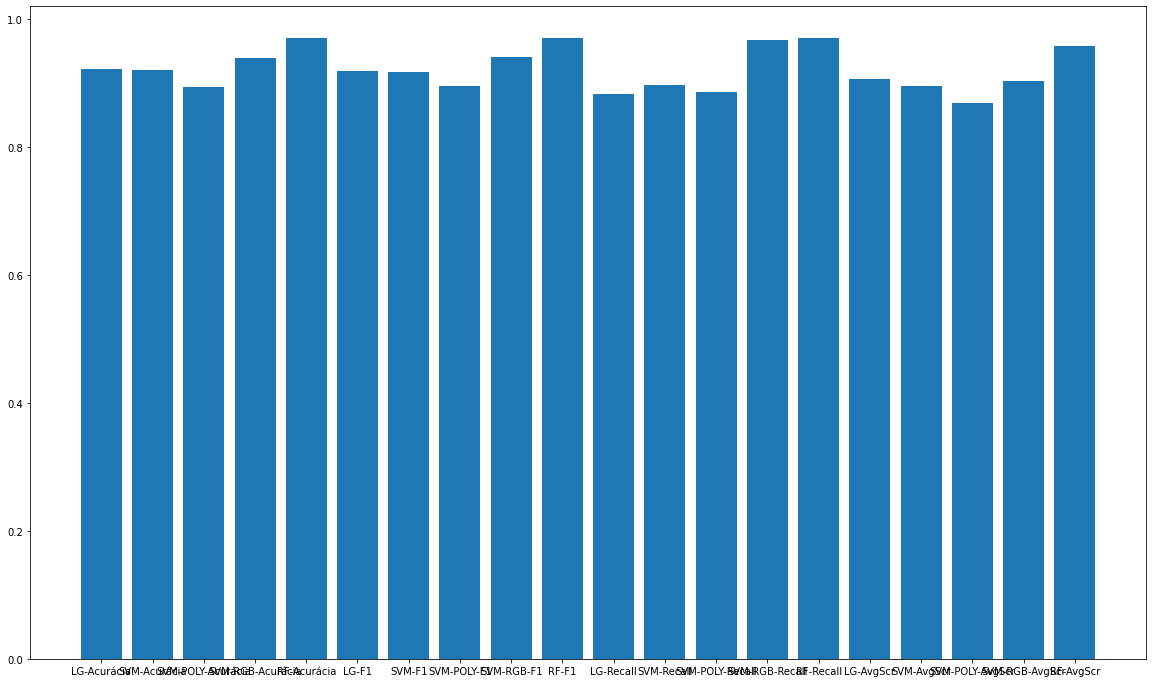

In [45]:
plt.figure(figsize=(20,12))
plt.bar(dt.columns,dt.iloc[1])